# SOLVING THE BLACK-SCHOLES EQUATION FOR A EUROPEAN CALL OPTION 

## Import needed packages

In [ ]:
import DGM
import tensorflow as tf
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

## Parameters 

In [ ]:
# Option parameters
r = 0.05           # Interest rate
sigma = 0.25       # Volatility
K = 50             # Strike
T = 1              # Terminal time
S0 = 0.5           # Initial price

# Solution parameters (domain on which to solve PDE)
t_low = 0 + 1e-10    # time lower bound
S_low = 0.0 + 1e-10  # spot price lower bound
S_high = 2*K         # spot price upper bound

# neural network parameters
num_layers = 3
nodes_per_layer = 50
learning_rate = 0.001

# Training parameters
sampling_stages  = 100   # number of times to resample new time-space domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 1000
nSim_terminal = 100
S_multiplier  = 1.5   # multiplier for oversampling i.e. draw S from [S_low, S_high * S_multiplier]

# Plot options
n_plot = 41  # Points on plot grid for each dimension

# Save options
saveOutput = False
saveName   = 'BlackScholes_EuropeanCall'
saveFigure = False
figureName = 'BlackScholes_EuropeanCall.png'


## Black-Scholes European call price function

In [ ]:
def BlackScholesCall(S, K, r, sigma, t):
    ''' Analytical solution for European call option price under Black-Scholes model 
    
    Args:
        S:     spot price
        K:     strike price
        r:     risk-free interest rate
        sigma: volatility
        t:     time
    ''' 
    
    d1 = (np.log(S/K) + (r + sigma**2 / 2) * (T-t))/(sigma * np.sqrt(T-t))
    d2 = d1 - (sigma * np.sqrt(T-t))

    callPrice = S * spstats.norm.cdf(d1) - K * np.exp(-r * (T-t)) * spstats.norm.cdf(d2)
    
    return callPrice

## Sampling function - randomly sample time-space pairs 

In [ ]:
def sampler(nSim_interior, nSim_terminal):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    ''' 
    
    # Sampler #1: domain interior
    t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    S_interior = np.random.uniform(low=S_low, high=S_high*S_multiplier, size=[nSim_interior, 1])

    # Sampler #2: spatial boundary
        # no spatial boundary condition for this problem
    
    # Sampler #3: initial/terminal condition
    t_terminal = T * np.ones((nSim_terminal, 1))
    S_terminal = np.random.uniform(low=S_low, high=S_high*S_multiplier, size = [nSim_terminal, 1])
    
    return t_interior, S_interior, t_terminal, S_terminal

## Loss function for Black-Scholes equation

In [ ]:
def loss(model, t_interior, S_interior, t_terminal, S_terminal):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        S_interior: sampled space points in the interior of the function's domain
        t_terminal: sampled time points at terminal point (vector of terminal times)
        S_terminal: sampled space points at terminal time
    ''' 
    
    # Loss term #1: PDE
    # compute function value and derivatives at current sampled points
    V = model(t_interior, S_interior)
    V_t = tf.gradients(V, t_interior)[0]
    V_s = tf.gradients(V, S_interior)[0]
    V_ss = tf.gradients(V_s, S_interior)[0]
    diff_V = V_t + 0.5 * sigma**2 * S_interior**2 * V_ss + r * S_interior * V_s - r*V

    # compute average L2-norm of differential operator
    L1 = tf.reduce_mean(tf.square(diff_V)) 
    
    # Loss term #2: boundary condition
        # no boundary condition for this problem
    
    # Loss term #3: initial/terminal condition
    target_payoff = tf.nn.relu(S_terminal - K)
    fitted_payoff = model(t_terminal, S_terminal)
    
    L3 = tf.reduce_mean( tf.square(fitted_payoff - target_payoff) )

    return L1, L3

## Set up DGM network

In [ ]:
# initialize DGM model (last input: space dimension = 1)
model = DGM.DGMNet(nodes_per_layer, num_layers, 1)

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_tnsr = tf.placeholder(tf.float32, [None,1])
S_interior_tnsr = tf.placeholder(tf.float32, [None,1])
t_terminal_tnsr = tf.placeholder(tf.float32, [None,1])
S_terminal_tnsr = tf.placeholder(tf.float32, [None,1])

# loss 
L1_tnsr, L3_tnsr = loss(model, t_interior_tnsr, S_interior_tnsr, t_terminal_tnsr, S_terminal_tnsr)
loss_tnsr = L1_tnsr + L3_tnsr

# option value function
V = model(t_interior_tnsr, S_interior_tnsr)

# set optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.global_variables_initializer()

# open session
sess = tf.Session()
sess.run(init_op)

## Train network

In [ ]:
# for each sampling stage
for i in range(sampling_stages):
    
    # sample uniformly from the required regions
    t_interior, S_interior, t_terminal, S_terminal = sampler(nSim_interior, nSim_terminal)
    
    # for a given sample, take the required number of SGD steps
    for _ in range(steps_per_sample):
        loss,L1,L3,_ = sess.run([loss_tnsr, L1_tnsr, L3_tnsr, optimizer],
                                feed_dict = {t_interior_tnsr:t_interior, S_interior_tnsr:S_interior, t_terminal_tnsr:t_terminal, S_terminal_tnsr:S_terminal})
    
    print(loss, L1, L3, i)

# save outout
if saveOutput:
    saver = tf.train.Saver()
    saver.save(sess, './SavedNets/' + saveName)

## Plot results

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


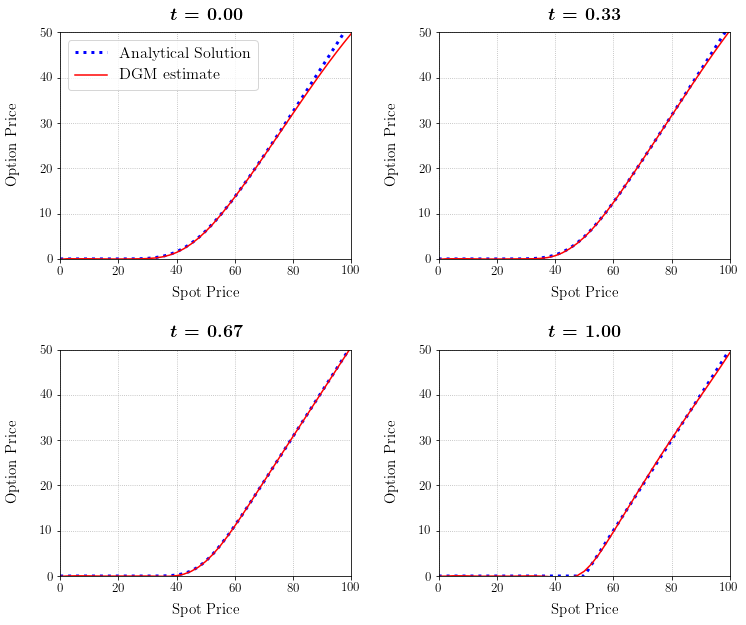

In [9]:
# LaTeX rendering for text in plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# figure options
plt.figure()
plt.figure(figsize = (12,10))

# time values at which to examine density
valueTimes = [t_low, T/3, 2*T/3, T]

# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_plot)

for i, curr_t in enumerate(valueTimes):
    
    # specify subplot
    plt.subplot(2,2,i+1)
    
    # simulate process at current t 
    optionValue = BlackScholesCall(S_plot, K, r, sigma, curr_t)
    
    # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
    
    # plot histogram of simulated process values and overlay estimated density
    plt.plot(S_plot, optionValue, color = 'b', label='Analytical Solution', linewidth = 3, linestyle=':')
    plt.plot(S_plot, fitted_optionValue[0], color = 'r', label='DGM estimate')    
    
    # subplot options
    plt.ylim(ymin=0.0, ymax=K)
    plt.xlim(xmin=0.0, xmax=S_high)
    plt.xlabel(r"Spot Price", fontsize=15, labelpad=10)
    plt.ylabel(r"Option Price", fontsize=15, labelpad=20)
    plt.title(r"\boldmath{$t$}\textbf{ = %.2f}"%(curr_t), fontsize=18, y=1.03)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(linestyle=':')
    
    if i == 0:
        plt.legend(loc='upper left', prop={'size': 16})
    
# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

if saveFigure:
    plt.savefig(figureName)
    
plt.show()